CS5242 Final Project : Model Training Notebook
===
> Transfer learning and fine-tuning pre-trained models on ImageNet dataset

*Murat Shagirov*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from os import path

import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15,5) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

In [3]:
from nn import train_model # model training function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from datautils import LoadTrainingData
from torch.utils.data import DataLoader
from torchvision import models, utils, transforms as T

from datautils import BatchUnnorm, Unnorm

# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

# Transforms
unnorm = Unnorm() # unnormalize a single RGB image
unnormb = BatchUnnorm() # unnormalize batch of images

toPIL = T.ToPILImage()

img_size = 512

transform = T.Compose([T.ToPILImage(),
                       T.RandomRotation((-3,3)),
                       T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
                       T.RandomHorizontalFlip(),
#                        T.Resize(img_size),
                       T.ToTensor(),
                       T.ConvertImageDtype(dtype), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = T.Compose([T.ToPILImage(),
                           T.Resize(img_size),
                           T.ToTensor(),
                           T.ConvertImageDtype(dtype),
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

np.random.seed(42) #seed np RNG for consistency
# split the original training data into 85% / 15% train/val datasets
datasets = LoadTrainingData(train_csv, train_data_path, transform=transform,
                            split=True, train_percent=80, val_transform=val_transform)

print(f"Training dataset: {len(datasets['train'])} samples.",
      f"\nValidation dataset: {len(datasets['val'])} samples.")


device: cuda
dtype: torch.float32
Training dataset: 931 samples. 
Validation dataset: 233 samples.


- fine tuning resnet18 seems faster, and validation set acc-y is generally quickly reaches >85-90% after 5epochs
- using resnet18's conv layer as feature extractor (freezing them) results in very slow training (but no overfitting), both training and val-n set accuracies increase slowly (>80% after 5 epochs)

In [16]:
num_epochs = 25

bsize_train = 4 # batch sizes
bsize_val = 4

lr = 0.01 # learning rate

# Download ImageNet pre-trained model from torchhub
model_ft = models.resnet34(pretrained=True,progress=False)

# # for transfer learning freeze (disable grads for early layers)
# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features

# size of each output sample: nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
# optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = None
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=14*len(datasets['train']), gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}

In [104]:
# for param_tensor in model_ft.state_dict():
#     print(param_tensor, "\t", model_ft.state_dict()[param_tensor].size())

Epoch 0/9 --- train Loss: 0.1321 Acc: 0.9549 || val Loss: 0.1416 Acc: 0.9528 || 36s
Epoch 1/9 --- train Loss: 0.1002 Acc: 0.9689 || val Loss: 0.1250 Acc: 0.9442 || 72s
Epoch 2/9 --- train Loss: 0.0995 Acc: 0.9710 || val Loss: 0.1485 Acc: 0.9528 || 107s
Epoch 3/9 --- train Loss: 0.0960 Acc: 0.9721 || val Loss: 0.1368 Acc: 0.9356 || 143s
Epoch 4/9 --- train Loss: 0.0827 Acc: 0.9774 || val Loss: 0.1355 Acc: 0.9399 || 180s
Epoch 5/9 --- train Loss: 0.0949 Acc: 0.9710 || val Loss: 0.1406 Acc: 0.9399 || 215s
Epoch 6/9 --- train Loss: 0.0984 Acc: 0.9731 || val Loss: 0.1392 Acc: 0.9399 || 251s
Epoch 7/9 --- train Loss: 0.0885 Acc: 0.9731 || val Loss: 0.1462 Acc: 0.9485 || 286s
Epoch 8/9 --- train Loss: 0.0805 Acc: 0.9731 || val Loss: 0.1408 Acc: 0.9485 || 322s
Epoch 9/9 --- train Loss: 0.0793 Acc: 0.9785 || val Loss: 0.1438 Acc: 0.9528 || 357s
Training complete in 5m 57s
Best val Acc: 0.952790 (return best:True)


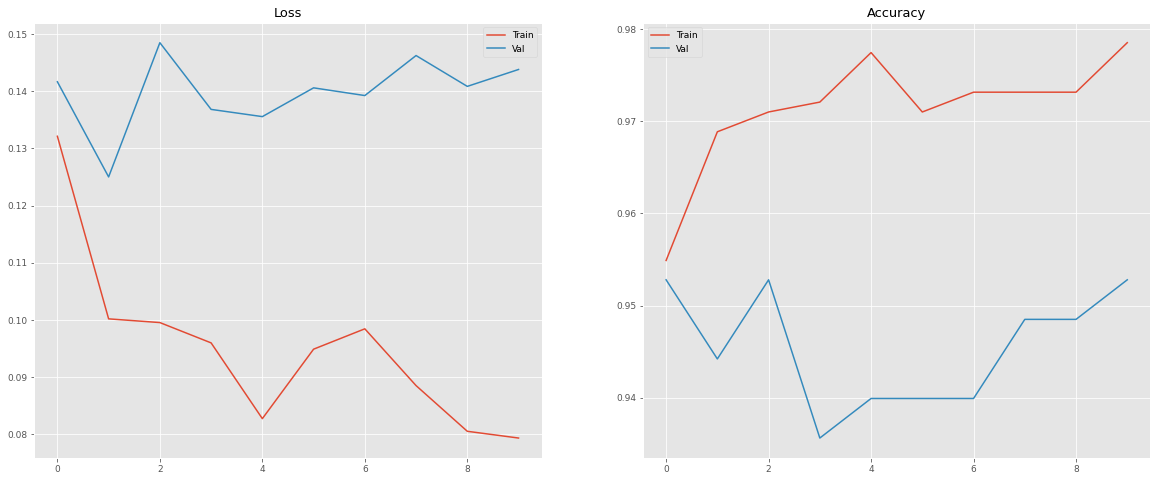

In [18]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

In [ ]:
# model.load_state_dict(torch.load(PATH))
# model.eval()
# best_model.load_state_dict(torch.load(f'./resnet18_e{20+num_epochs}_ft.pkl')

In [19]:
train_method = 'ft'
save_dir = '../../dataDIR/cs5242/'
weights_path = path.join(save_dir, f'resnet34_e{num_epochs}_{train_method}_V1.pkl')
torch.save(best_model.state_dict(), weights_path)
torch.save(curve_data,f'./resnet34_e{num_epochs}_{train_method}_curvesV1.pkl')

In [20]:
# from datautils import BatchUnnorm, Unnorm

# unnorm = Unnorm() # unnormalize a single RGB image
# unnormb = BatchUnnorm() # unnormalize batch of images

# for k, sample in enumerate(data_loaders['train']):
#     print(f'Sample {k}: x {sample["image"].shape}; Labels {sample["label"].tolist()}')
#     grid = utils.make_grid(unnormb(sample['image']), padding=4, pad_value=1.)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))
#     plt.title(f'Labels:{sample["label"].tolist()}')
#     plt.axis(False)
#     plt.show()
#     break

## Transfer Learning

In [9]:
num_epochs = 100

bsize_train = 4 # batch sizes
bsize_val = 4

lr = 0.01 # learning rate

# Download ImageNet pre-trained model from torchhub
model_ft = models.resnet34(pretrained=True,progress=False)

# for transfer learning freeze (disable grads for early layers)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features

# size of each output sample: nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=0.9)
# optimizer_ft = torch.optim.Adam(model_ft.fc.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = None
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20*len(datasets['train']), gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# Prepare dataloaders
data_loaders = {'train' : DataLoader(datasets['train'], batch_size=bsize_train, shuffle=True, num_workers=0),
                'val'   : DataLoader(datasets['val'],  batch_size=bsize_val, shuffle=False, num_workers=0)}

SGD moment0.9 lr=0.01: >90% (25 epochs)<br>
SGD //-// lr= 0.01 step(20 epochs decay): 92% (100 epochs), <br>

Epoch 0/99 --- train Loss: 0.7699 Acc: 0.8808 || val Loss: 0.9628 Acc: 0.8712 || 35s
Epoch 1/99 --- train Loss: 0.6881 Acc: 0.8894 || val Loss: 0.9157 Acc: 0.8927 || 70s
Epoch 2/99 --- train Loss: 0.6923 Acc: 0.8797 || val Loss: 0.6998 Acc: 0.9013 || 106s
Epoch 3/99 --- train Loss: 0.9769 Acc: 0.8700 || val Loss: 0.9197 Acc: 0.8927 || 141s
Epoch 4/99 --- train Loss: 0.8144 Acc: 0.8894 || val Loss: 0.9615 Acc: 0.8584 || 175s
Epoch 5/99 --- train Loss: 0.7906 Acc: 0.8797 || val Loss: 0.9506 Acc: 0.8755 || 209s
Epoch 6/99 --- train Loss: 0.5673 Acc: 0.9055 || val Loss: 0.9373 Acc: 0.8884 || 245s
Epoch 7/99 --- train Loss: 0.6639 Acc: 0.8926 || val Loss: 0.9676 Acc: 0.8712 || 279s
Epoch 8/99 --- train Loss: 0.8673 Acc: 0.8743 || val Loss: 1.2342 Acc: 0.8627 || 312s
Epoch 9/99 --- train Loss: 0.6153 Acc: 0.8937 || val Loss: 1.2540 Acc: 0.8584 || 346s
Epoch 10/99 --- train Loss: 0.6935 Acc: 0.8894 || val Loss: 1.1223 Acc: 0.8584 || 382s
Epoch 11/99 --- train Loss: 0.7358 Acc: 0.8808 || val L

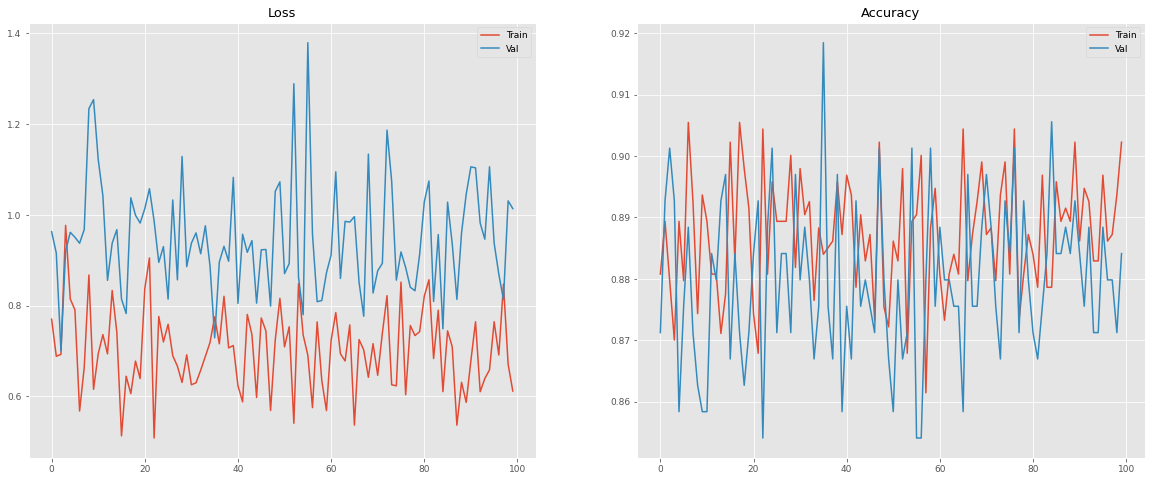

In [13]:
best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
                         loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

plt.figure(figsize=[20,8])
t = np.arange(curve_data['total_epochs'])
plt.subplot(121)
plt.plot(t,curve_data['trainLosses'],label='Train')
plt.plot(t,curve_data['valLosses'],label='Val')
plt.title('Loss'); plt.legend()

plt.subplot(122)
plt.plot(t,curve_data['trainAccs'],label='Train')
plt.plot(t,curve_data['valAccs'],label='Val')
plt.title('Accuracy'); plt.legend()

plt.show()

In [ ]:
# num_epochs = 50

# # re-enable grads for fine-tuning
# for param in model_ft.parameters():
#     param.requires_grad = True
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00001, momentum=0.9)
# # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
# exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, 10**-9, 10**-4,
#                                          step_size_up=5, step_size_down=10)

# best_model, curve_data  = train_model(model_ft, optimizer_ft, data_loaders, num_epochs=num_epochs,
#                          loss_func=criterion, scheduler=exp_lr_scheduler, device=device, return_best=True)

# plt.figure(figsize=[20,8])
# t = np.arange(curve_data['total_epochs'])
# plt.subplot(121)
# plt.plot(t,curve_data['trainLosses'],label='Train')
# plt.plot(t,curve_data['valLosses'],label='Val')
# plt.title('Loss'); plt.legend()

# plt.subplot(122)
# plt.plot(t,curve_data['trainAccs'],label='Train')
# plt.plot(t,curve_data['valAccs'],label='Val')
# plt.title('Accuracy'); plt.legend()

# plt.show()

In [ ]:
train_method = 'trft'
save_dir = '../../dataDIR/cs5242/'
weights_path = path.join(save_dir, f'resnet34_{train_method}_V3.pkl')
torch.save(best_model.state_dict(), weights_path)
torch.save(curve_data,f'./resnet34_{train_method}_curvesV3.pkl')